# Anticipez  les besoins en consommation de bâtiments
## Modélisation EnergyUse(kBtu)

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

In [2]:
data = pd.read_csv('data_cleaned.csv')

In [3]:
data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,SteamBool,GasBool
0,NonResidential,Hotel,DOWNTOWN,1926,1.0,11,0,83008,27.0,5758795.000,176.14,False,True
1,NonResidential,Other,DOWNTOWN,1926,1.0,8,0,102761,NaN,6298131.500,221.51,True,True
2,Multifamily MR (5-9),Mid-Rise Multifamily,DOWNTOWN,1910,1.0,6,1496,62216,1.0,4573777.000,151.12,True,True
3,NonResidential,Hotel,NORTHEAST,2001,1.0,6,30586,58006,84.0,3663534.500,90.01,False,True
4,NonResidential,Other,DOWNTOWN,1930,1.0,2,0,67224,NaN,1310236.625,9.13,False,False


In [4]:
data.shape

(2758, 13)

# Répartition des données

In [5]:
# Définition des targets
targets = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

# Suppression de la variable ENERGYSTARScore du dataset
ES_Score = 'ENERGYSTARScore'
X = data.drop(columns = targets)
X.drop(columns = ES_Score, inplace=True)

y = data[targets[1]]
# y = data[targets[0]]

In [6]:
X.shape

(2758, 10)

In [7]:
y.shape

(2758,)

In [8]:
X.dtypes

BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
YearBuilt                   int64
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFAParking          int64
PropertyGFABuilding(s)      int64
SteamBool                    bool
GasBool                      bool
dtype: object

## Train test split

In [9]:
# passage au log de la target pour comparaison des résultats
y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1000) # 42 for linear bug 
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, train_size=0.8, random_state=1000) # 42 for linear bug 


## Standardisation
- Tri entre numeric et categoric =>  include= number OR include=object, bool
- définir les pipelines => num_pipeline (StandardScaler) & cat_pipeline (OneHotEncoder)
- injecter pipelines dans ColumnTransformer
- Pipeline avec ColumnTransformer + model

In [10]:
def prepocessor_pipe(X):
    """ Fonction de définition des Pipelines pour les variables catégoriques et numériques """
    
    ### Pipeline pour numeric features : Simple Imputer, StandardScaler
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='mean')), # In case there is missing values
        ('scale', StandardScaler())
    ])

    # Pipeline pour categoric features : Simple Imputer, OneHoteEncoder, StandardScaler
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')), # In case there is missing values
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
        ('scale', StandardScaler())
    ])

    # ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, X.select_dtypes(include='number').columns),
        ('cat', cat_pipeline, X.select_dtypes(include=['object', 'bool']).columns)
    ])
    return preprocessor

preprocessor = prepocessor_pipe(X)

In [11]:
def model_pipe(preprocessor, regressor):
    """ Fonction de définition des modèles, afin d'utiliser le même pipeline de preprocessing pour chaque modèles """
    
    pipe = Pipeline(steps=[
        ('preproc', preprocessor),
        ('model', regressor)
    ])
    return pipe

In [12]:
# Initialisation des variables afin de pouvoir relancer le notebook sans overwritting
score = pd.DataFrame()
bestparams = pd.DataFrame()

## Dummy regression

In [13]:
from sklearn.dummy import DummyRegressor

pipe = model_pipe(preprocessor, DummyRegressor())

from sklearn import set_config

set_config(display='diagram')
display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'SteamBool',
       'GasBool'],
      dtype='object'))])),
                ('model', DummyRegressor())])

Baseline model score: -0.0015736885871167061


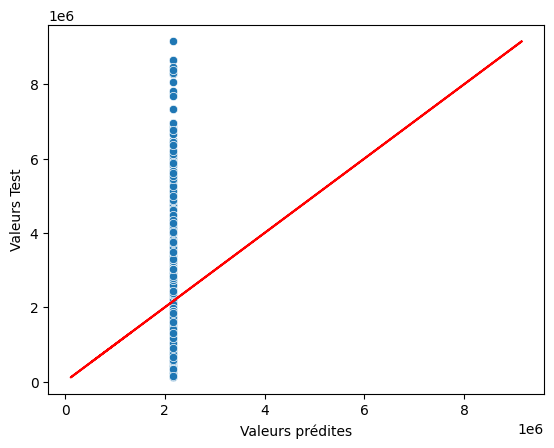

In [14]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print("Baseline model score: {}".format(pipe.score(X_test, y_test))) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

# Modèles
Premier test de modèles dans les versions par défaults :
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net
- kNN
- SVR
- Neuron Network
- Random Forest
- Adaboost
- XGBoost

## Linear Regression

Model score: 0.6894824745641155


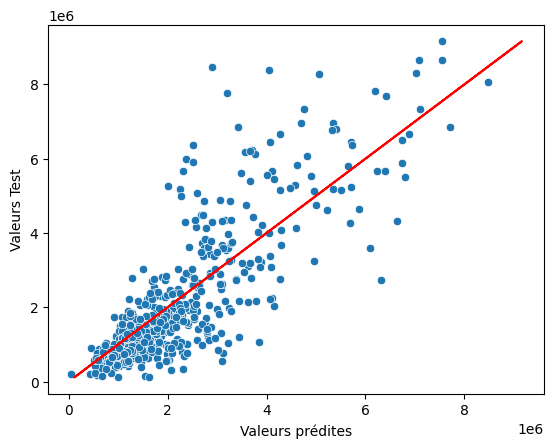

In [15]:
from sklearn.linear_model import LinearRegression

pipe = model_pipe(preprocessor, LinearRegression())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print("Model score: {}".format(pipe.score(X_test, y_test))) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

Model score: 0.622448834214253


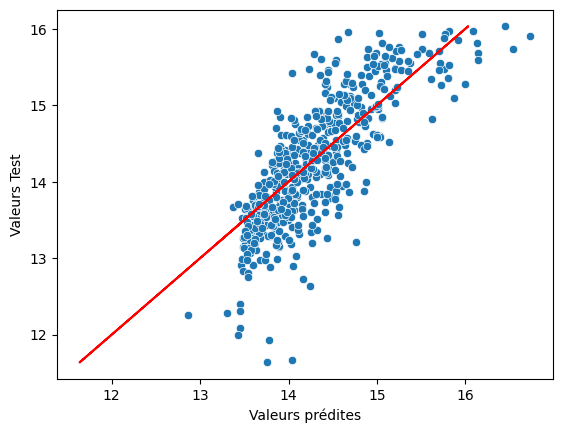

In [16]:
from sklearn.linear_model import LinearRegression

pipe = model_pipe(preprocessor, LinearRegression())

pipe.fit(X_train_log, y_train_log)

y_pred_log = pipe.predict(X_test_log)

print("Model score: {}".format(pipe.score(X_test_log, y_test_log))) # accuracy

sns.scatterplot(x=y_pred_log, y=y_test_log)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test_log, y_test_log, color='red')

## Linear Ridge

Model score: 0.689


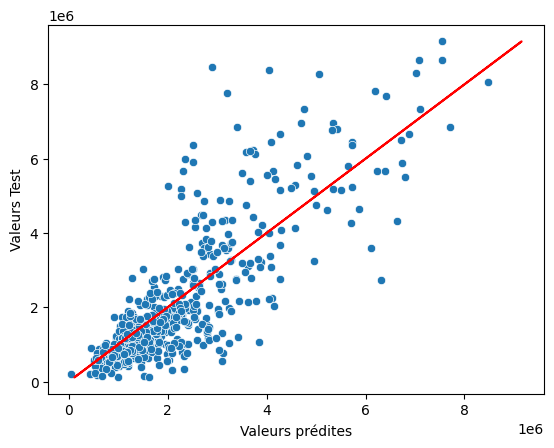

In [17]:
from sklearn.linear_model import Ridge

pipe = model_pipe(preprocessor, Ridge())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Ridge Regression', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Ridge Regression', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Linear Lasso

Model score: 0.689


C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.674e+12, tolerance: 7.379e+11
  model = cd_fast.enet_coordinate_descent(


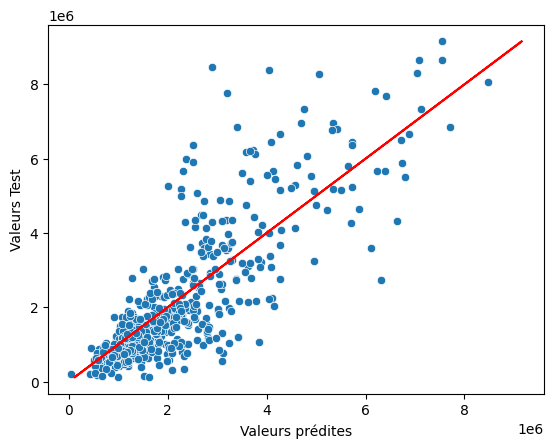

In [18]:
from sklearn.linear_model import Lasso

pipe = model_pipe(preprocessor, Lasso())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Lasso Regression', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Lasso Regression', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Elastic Net

Model score: 0.62


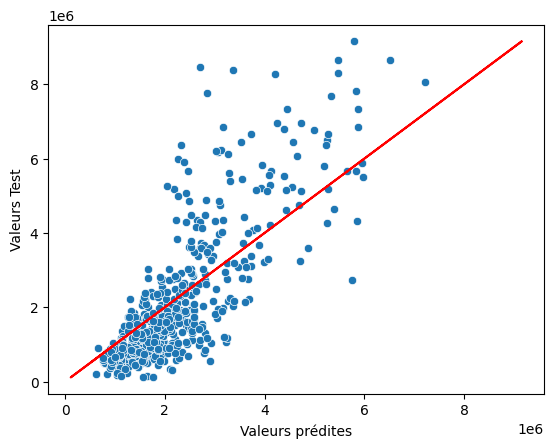

In [19]:
from sklearn.linear_model import ElasticNet

pipe = model_pipe(preprocessor, ElasticNet())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Elastic Net', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Elastic Net', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## kNN

Model score: 0.503


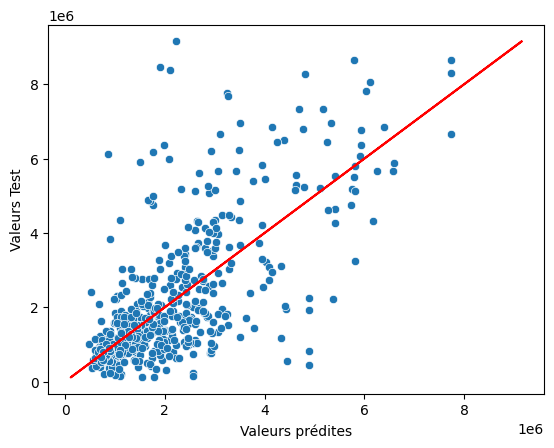

In [20]:
from sklearn.neighbors import KNeighborsRegressor

pipe = model_pipe(preprocessor, KNeighborsRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['kNN', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['kNN', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## SVR

Model score: -0.1


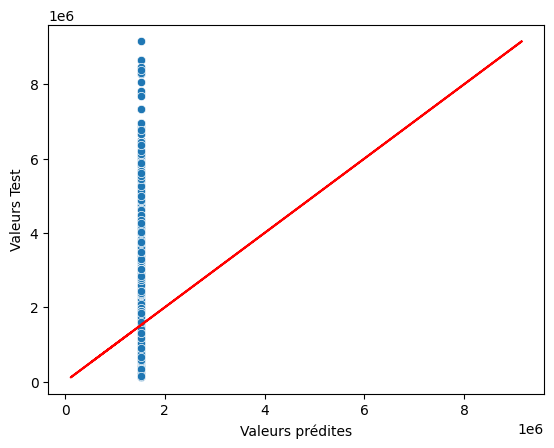

In [21]:
from sklearn.svm import SVR

pipe = model_pipe(preprocessor, SVR(kernel='rbf'))

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['SVR', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['SVR', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Neuron Network

Model score: -1.332


C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


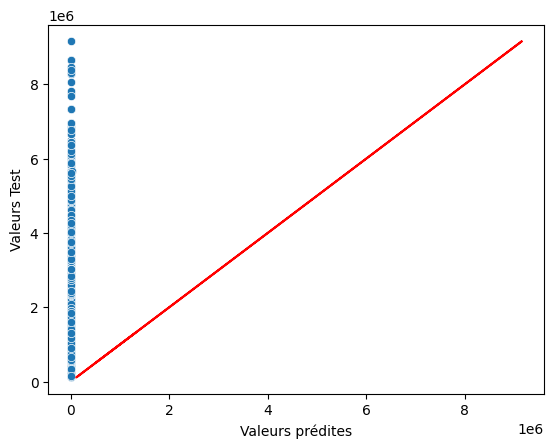

In [22]:
from sklearn.neural_network import MLPRegressor

pipe = model_pipe(preprocessor, MLPRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Neuron Network', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Neuron Network', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Random Forest

Model score: 0.685


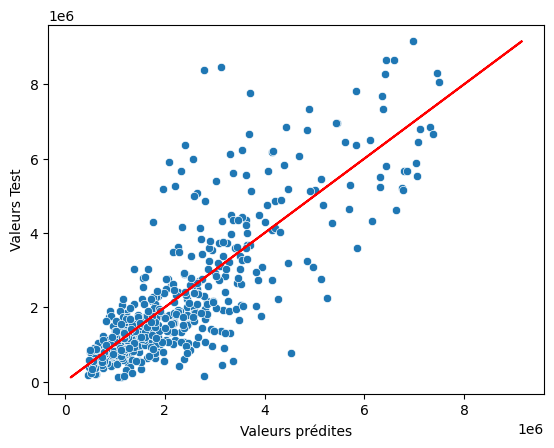

In [23]:
from sklearn.ensemble import RandomForestRegressor

pipe = model_pipe(preprocessor, RandomForestRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Random Forest', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Random Forest', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Adaboost

Model score: 0.131


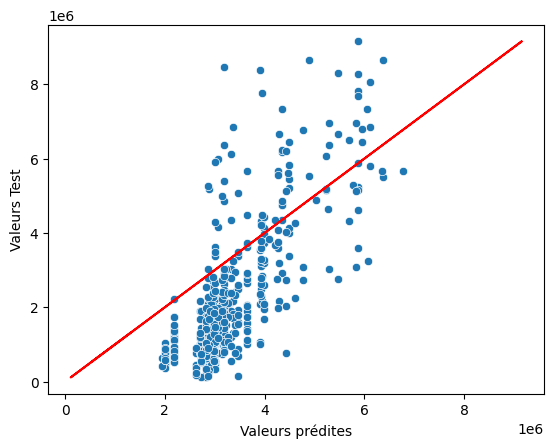

In [24]:
from sklearn.ensemble import AdaBoostRegressor
pipe = model_pipe(preprocessor, AdaBoostRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Adaboost', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Adaboost', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## XGBoosting

Model score: 0.666


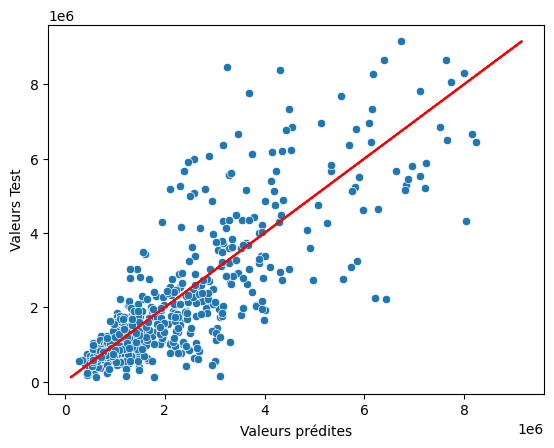

In [25]:
import xgboost as xg

pipe = model_pipe(preprocessor, xg.XGBRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['XGBoost', 'R2'] = round(pipe.score(X_test, y_test),3)

print("Model score: {}".format(score.loc['XGBoost', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Premiers résultats

In [26]:
score

,R2
Ridge Regression,0.689
Lasso Regression,0.689
Elastic Net,0.620
kNN,0.503
SVR,-0.100
Neuron Network,-1.332
Random Forest,0.685
Adaboost,0.131
XGBoost,0.666


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Neuron Network'),
  Text(1, 0, 'SVR'),
  Text(2, 0, 'Adaboost'),
  Text(3, 0, 'kNN'),
  Text(4, 0, 'Elastic Net'),
  Text(5, 0, 'XGBoost'),
  Text(6, 0, 'Random Forest'),
  Text(7, 0, 'Ridge Regression'),
  Text(8, 0, 'Lasso Regression')])

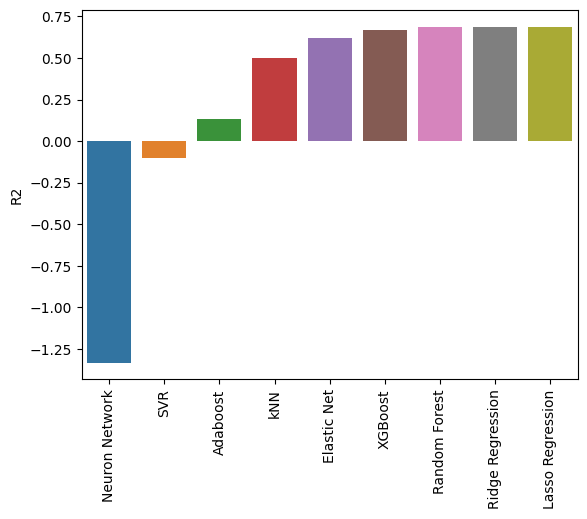

In [27]:
sns.barplot(data=score.sort_values(by='R2'), x=score.sort_values(by='R2').index, y='R2')
plt.xticks(rotation=90)

# GridSearchCV
Optimisation des modèles, et sauvegarde des scores

## Echelle d'origine

In [28]:
# Définition de la grille des hyperparamètres pour chaque modèle
param_grid_ridge = {'model__alpha': np.logspace(-3, 1, 5)}
param_grid_lasso = {'model__alpha': np.logspace(-3, 1, 5)}
param_grid_elastic = {'model__alpha': np.logspace(-3, 1, 5)}
param_grid_knn = {'model__n_neighbors':[3, 5, 7, 9, 11, 13, 15],
                  'model__weights': ['uniform', 'distance']}
param_grid_svr = {"model__kernel": ["linear", "rbf", "poly"]}
param_grid_neuron = {'model__activation': ['identity', 'logistic', 'relu']}
param_grid_rf = {'model__n_estimators': [10, 100, 1000],
                 'model__max_depth': [None, 10, 20],
                 'model__min_samples_split': [2, 5, 10]}
param_grid_ada = {'model__n_estimators': [50, 100, 200],
                  'model__learning_rate': [0.01, 0.1, 1],
                  'model__loss': ['linear', 'square', 'exponential']}
param_grid_xg = {'model__learning_rate': [0.01, 0.1, 0.5],
                 'model__max_depth': [3, 5, 7],
                 'model__min_child_weight': [1, 3, 5],
                 'model__subsample': [0.5, 0.7, 1],
                 'model__colsample_bytree': [0.5, 0.7, 1]}


# Création d'une liste de tuples pour pouvoir les itérer dans une boucle for
models = [
    ('Ridge Regression', model_pipe(preprocessor, Ridge()), param_grid_ridge),
    ('Lasso Regression', model_pipe(preprocessor, Lasso()), param_grid_lasso),
    ('Elastic Net', model_pipe(preprocessor, ElasticNet()), param_grid_elastic),
    ('kNN', model_pipe(preprocessor, KNeighborsRegressor()), param_grid_knn),
    ('SVR', model_pipe(preprocessor, SVR()), param_grid_svr),
    ('Neuron Network', model_pipe(preprocessor, MLPRegressor()), param_grid_neuron),
    ('Random Forest', model_pipe(preprocessor, RandomForestRegressor()), param_grid_rf),
    ('Adaboost', model_pipe(preprocessor, AdaBoostRegressor()), param_grid_ada),
    ('XGBoost', model_pipe(preprocessor, xg.XGBRegressor()), param_grid_xg)
     ]

# Définition de la cross-validation
cv_folds = KFold(n_splits=10, shuffle=True, random_state=1000)
CV_results = {}

# Iteration sur la liste des modèles pour effectuer la recherche des meilleurs hyperparamètres pour chacun
for name, model, param in models:
    print('GridSearchCV pour :', name)
    
    CV_results[name] = GridSearchCV(estimator=model, param_grid=param, scoring='r2', cv=cv_folds)
    CV_results[name].fit(X_train, y_train)
    
    # Stockage du score r2 test dans variable score et affichage
    score.loc[name, 'R2_cv'] = round(CV_results[name].score(X_test, y_test), 3)
    print(name, "best parameters:", CV_results[name].best_params_)
    print("{} R2 score: {:.3f}\n".format(name, CV_results[name].score(X_test, y_test)),)

GridSearchCV pour : Ridge Regression
Ridge Regression best parameters: {'model__alpha': 10.0}
Ridge Regression R2 score: 0.689

GridSearchCV pour : Lasso Regression


C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.221e+11, tolerance: 6.708e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e+14, tolerance: 6.592e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.171e+12, toleranc

C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.886e+11, tolerance: 6.708e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e+14, tolerance: 6.592e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.172e+12, toleranc

Lasso Regression best parameters: {'model__alpha': 0.001}
Lasso Regression R2 score: 0.689

GridSearchCV pour : Elastic Net


C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+15, tolerance: 6.650e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.031e+15, tolerance: 6.623e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e+15, toleranc

Elastic Net best parameters: {'model__alpha': 0.1}
Elastic Net R2 score: 0.684

GridSearchCV pour : kNN
kNN best parameters: {'model__n_neighbors': 13, 'model__weights': 'distance'}
kNN R2 score: 0.536

GridSearchCV pour : SVR
SVR best parameters: {'model__kernel': 'linear'}
SVR R2 score: -0.098

GridSearchCV pour : Neuron Network


C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Neuron Network best parameters: {'model__activation': 'relu'}
Neuron Network R2 score: -1.332

GridSearchCV pour : Random Forest
Random Forest best parameters: {'model__max_depth': None, 'model__min_samples_split': 10, 'model__n_estimators': 1000}
Random Forest R2 score: 0.687

GridSearchCV pour : Adaboost
Adaboost best parameters: {'model__learning_rate': 0.01, 'model__loss': 'exponential', 'model__n_estimators': 200}
Adaboost R2 score: 0.550

GridSearchCV pour : XGBoost
XGBoost best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__subsample': 0.7}
XGBoost R2 score: 0.709



## Echelle log

In [29]:
# Version log
# Iteration sur la liste des modèles pour effectuer la recherche des meilleurs hyperparamètres pour chacun

CV_results_log = {}
for name, model, param in models:
    print('GridSearchCV pour :', name)
    
    CV_results_log[name] = GridSearchCV(estimator=model, param_grid=param, scoring='r2', cv=cv_folds)
    CV_results_log[name].fit(X_train_log, y_train_log)
    
    # Stockage du score r2 test dans variable score et affichage
    score.loc[name, 'R2_cv_log'] = round(CV_results_log[name].score(X_test_log, y_test_log), 3)
    print(name, "best parameters:", CV_results_log[name].best_params_)
    print("{} R2 score: {:.3f}\n".format(name, CV_results_log[name].score(X_test_log, y_test_log)),)

GridSearchCV pour : Ridge Regression
Ridge Regression best parameters: {'model__alpha': 10.0}
Ridge Regression R2 score: 0.622

GridSearchCV pour : Lasso Regression
Lasso Regression best parameters: {'model__alpha': 0.01}
Lasso Regression R2 score: 0.610

GridSearchCV pour : Elastic Net


C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e-01, tolerance: 1.273e-01
  model = cd_fast.enet_coordinate_descent(


Elastic Net best parameters: {'model__alpha': 0.01}
Elastic Net R2 score: 0.617

GridSearchCV pour : kNN
kNN best parameters: {'model__n_neighbors': 11, 'model__weights': 'distance'}
kNN R2 score: 0.524

GridSearchCV pour : SVR
SVR best parameters: {'model__kernel': 'rbf'}
SVR R2 score: 0.668

GridSearchCV pour : Neuron Network


C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Neuron Network best parameters: {'model__activation': 'logistic'}
Neuron Network R2 score: 0.616

GridSearchCV pour : Random Forest
Random Forest best parameters: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 1000}
Random Forest R2 score: 0.675

GridSearchCV pour : Adaboost
Adaboost best parameters: {'model__learning_rate': 0.01, 'model__loss': 'exponential', 'model__n_estimators': 200}
Adaboost R2 score: 0.523

GridSearchCV pour : XGBoost
XGBoost best parameters: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__subsample': 0.7}
XGBoost R2 score: 0.716



# Interprétation

## Scores

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcul des score RMSE et MAE
for name, model in CV_results.items():
    y_pred = model.best_estimator_.predict(X_test)
    score.loc[name, 'RMSE'] = round((mean_squared_error(y_test, y_pred) ** 0.5), 3)
    score.loc[name, 'MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calcul des score RMSE et MAE LOG
for name, model in CV_results_log.items():
    y_pred_log = model.best_estimator_.predict(X_test_log)
    score.loc[name, 'R2_log2lin'] = round(r2_score(np.exp(y_test_log), np.exp(y_pred_log)), 3)
    score.loc[name, 'RMSE_log2lin'] = round((mean_squared_error(np.exp(y_test_log), np.exp(y_pred_log)) ** 0.5), 3)
    score.loc[name, 'MAE_log2lin'] = round(mean_absolute_error(np.exp(y_test_log), np.exp(y_pred_log)), 3)

In [31]:
score

,R2,R2_cv,R2_cv_log,RMSE,MAE,R2_log2lin,RMSE_log2lin,MAE_log2lin
Ridge Regression,0.689,0.689,0.622,1012712.845,684504.166,0.478,1311283.597,779289.095
Lasso Regression,0.689,0.689,0.610,1011804.027,683647.310,0.485,1303059.939,788634.922
Elastic Net,0.620,0.684,0.617,1021259.698,693972.978,0.488,1299448.219,782217.242
kNN,0.503,0.536,0.524,1236805.410,816366.083,0.487,1300599.193,798750.073
SVR,-0.100,-0.098,0.668,1902262.463,1246423.076,0.677,1031715.266,662087.320
Neuron Network,-1.332,-1.332,0.616,2772781.335,2097553.555,0.521,1256616.676,768220.682
Random Forest,0.685,0.687,0.675,1016487.222,679814.878,0.674,1037485.444,648470.350
Adaboost,0.131,0.550,0.523,1218126.055,898477.619,0.481,1307648.135,822355.845
XGBoost,0.666,0.709,0.716,979166.957,662704.330,0.726,949720.626,607783.495


In [32]:
# Changement d'index pour faciliter les affichages
score.reset_index(inplace=True)
score.rename(columns={'index':'model'}, inplace=True)

### Comparaison Modèles et échelles

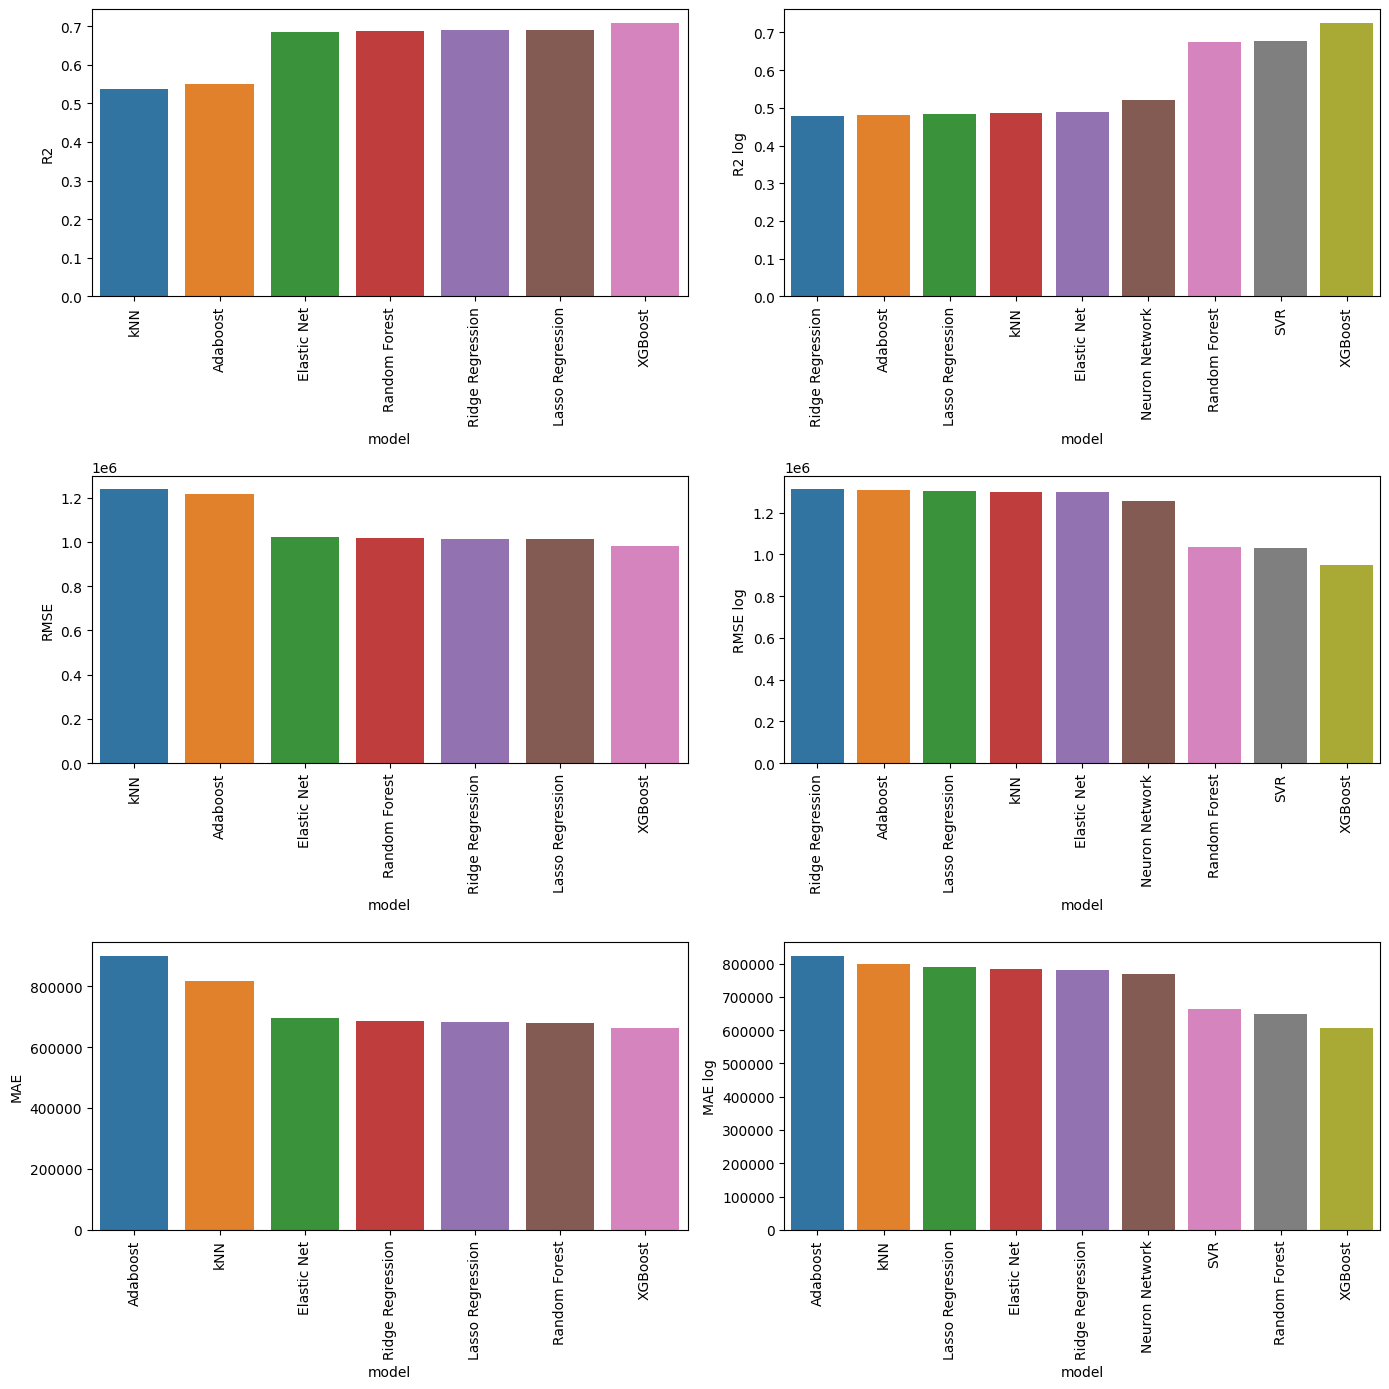

In [33]:
# Création de la figure et des sous-figures
fig, axs = plt.subplots(3, 2, figsize=(14, 14))

# Barplot pour le score R2
sns.barplot(data=score.sort_values(by='R2_cv').iloc[2:,:], x='model', y='R2_cv', ax=axs[0,0])
axs[0,0].set_ylabel('R2')
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le score R2_log
sns.barplot(data=score.sort_values(by='R2_log2lin'), x='model', y='R2_log2lin', ax=axs[0,1])
axs[0,1].set_ylabel('R2 log')
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le RMSE
sns.barplot(data=score.sort_values(by='RMSE', ascending=False).iloc[2:,:], x='model', y='RMSE', ax=axs[1,0])
axs[1,0].set_ylabel('RMSE')
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le RMSE_log
sns.barplot(data=score.sort_values(by='RMSE_log2lin', ascending=False), x='model', y='RMSE_log2lin', ax=axs[1,1])
axs[1,1].set_ylabel('RMSE log')
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le MAE
sns.barplot(data=score.sort_values(by='MAE', ascending=False).iloc[2:,:], x='model', y='MAE', ax=axs[2,0])
axs[2,0].set_ylabel('MAE')
axs[2,0].set_xticklabels(axs[2,0].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le MAE_log
sns.barplot(data=score.sort_values(by='MAE_log2lin', ascending=False), x='model', y='MAE_log2lin', ax=axs[2,1])
axs[2,1].set_ylabel('MAE log')
axs[2,1].set_xticklabels(axs[2,1].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Affichage de la figure
plt.tight_layout()
plt.show()

### Best model : XGBoost
### Comparaison des échelles pour XGBoost

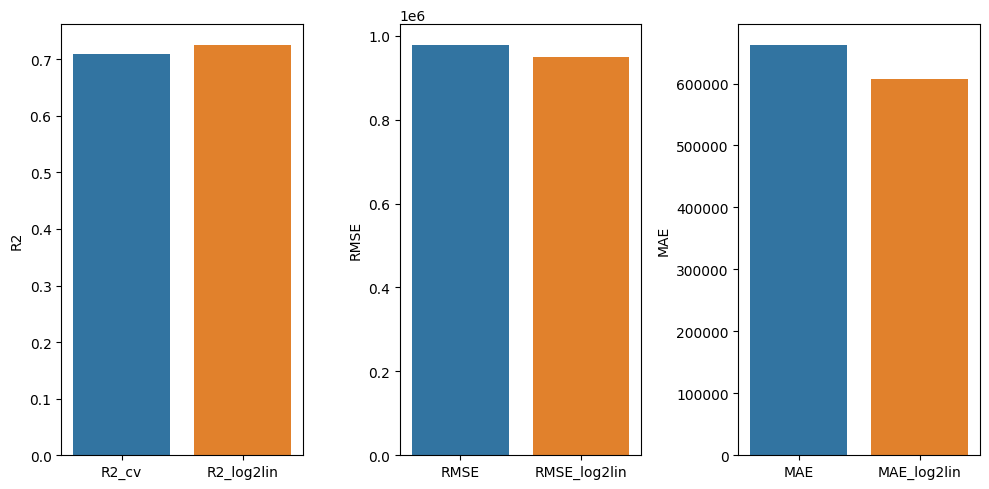

In [34]:

# Création de la figure et des sous-figures
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Barplot pour le score R2
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['R2_cv', 'R2_log2lin']], ax=axs[0])
axs[0].set_ylabel('R2')

# Barplot pour le RMSE
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['RMSE', 'RMSE_log2lin']], ax=axs[1])
axs[1].set_ylabel('RMSE')

# Barplot pour le MAE
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['MAE', 'MAE_log2lin']], ax=axs[2])
axs[2].set_ylabel('MAE')

# Affichage de la figure
plt.tight_layout()
plt.show()

In [35]:
print("Score R2 :", r2_score(y_test, y_pred))

Score R2 : 0.7091931065407626


In [36]:
print("Score R2_log2lin :", r2_score(np.exp(y_test_log), np.exp(y_pred_log)))

Score R2_log2lin : 0.7264208863211334


## Meilleur échelle : Log

Text(0.5, 1.0, 'Valeurs réelles vs Prédictions (logarithme)')

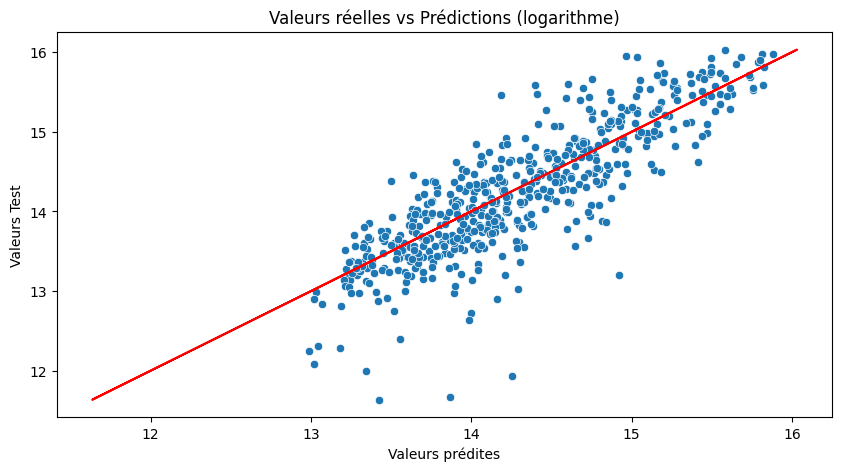

In [37]:
# Stockage du meilleur modèle dans best_model
best_model = CV_results_log['XGBoost'].best_estimator_
y_pred_log = best_model.predict(X_test_log)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_log, y=y_test_log)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test_log, y_test_log, color='red')
plt.title('Valeurs réelles vs Prédictions (logarithme)')

#### Remise à l'échelle des valeurs

Text(0.5, 1.0, 'Valeurs réelles vs Prédictions')

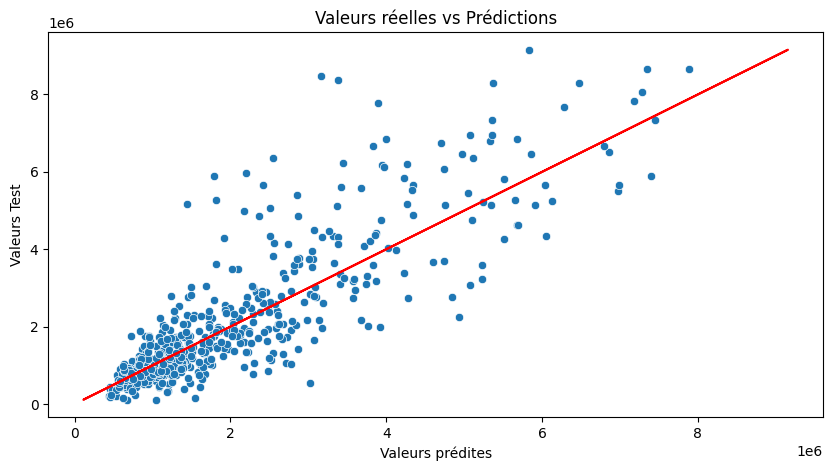

In [38]:
y_pred_log = best_model.predict(X_test_log)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x=np.exp(y_pred_log), y=np.exp(y_test_log))
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(np.exp(y_test_log), np.exp(y_test_log), color='red')
plt.title('Valeurs réelles vs Prédictions')

## Features importance

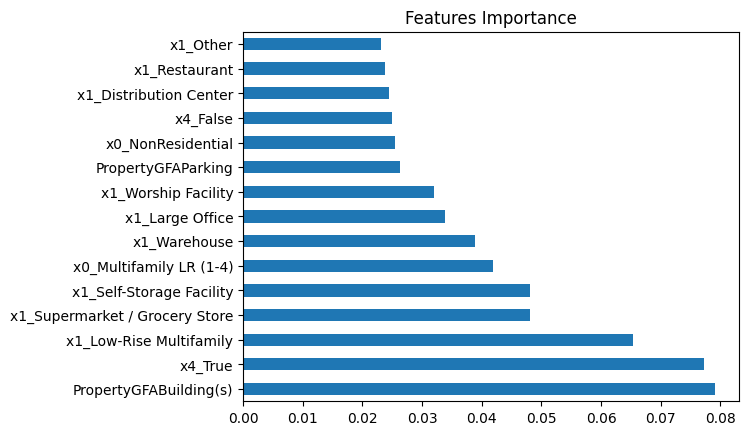

In [39]:
# Récupération des features après OneHotEncoder
num_feature_names = X.select_dtypes(include='number').columns.tolist()
cat_transformer = best_model.named_steps['preproc'].named_transformers_['cat']
cat_feature_names = cat_transformer.named_steps['one-hot'].get_feature_names_out().tolist()
feature_names = num_feature_names + cat_feature_names

# Affichage des scores d'importance des features
feature_importances = pd.Series(best_model.named_steps['model'].feature_importances_, index=feature_names)
feature_importances.nlargest(15).plot(kind='barh')
plt.title('Features Importance')
plt.show()

In [40]:
feature_importances.tail()

x2_SOUTHWEST    0.007960
x3_False        0.006906
x3_True         0.015826
x4_False        0.024895
x4_True         0.077272
dtype: float32

# Influence ENERGYSTARScore 

Relance du GridSearch **avec** la variable ENERGYSTARScore ajoutée au dataset

In [41]:
X = data.drop(columns = targets)
X.dtypes

BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
YearBuilt                   int64
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFAParking          int64
PropertyGFABuilding(s)      int64
ENERGYSTARScore           float64
SteamBool                    bool
GasBool                      bool
dtype: object

In [42]:
X_trainES, X_testES, y_trainES, y_testES = train_test_split(X, y_log, train_size=0.8, random_state=1000) # 42 for linear bug

preprocessor = prepocessor_pipe(X)

In [43]:
# Version log avec ES

# Création d'une liste de tuples pour pouvoir les itérer dans une boucle for
models = [
    ('Ridge Regression', model_pipe(preprocessor, Ridge()), param_grid_ridge),
    ('Lasso Regression', model_pipe(preprocessor, Lasso()), param_grid_lasso),
    ('Elastic Net', model_pipe(preprocessor, ElasticNet()), param_grid_elastic),
    ('kNN', model_pipe(preprocessor, KNeighborsRegressor()), param_grid_knn),
    ('SVR', model_pipe(preprocessor, SVR()), param_grid_svr),
    ('Neuron Network', model_pipe(preprocessor, MLPRegressor()), param_grid_neuron),
    ('Random Forest', model_pipe(preprocessor, RandomForestRegressor()), param_grid_rf),
    ('Adaboost', model_pipe(preprocessor, AdaBoostRegressor()), param_grid_ada),
    ('XGBoost', model_pipe(preprocessor, xg.XGBRegressor()), param_grid_xg)
     ]

CV_results_ES = {}

# Iteration sur la liste des modèles pour effectuer la recherche des meilleurs hyperparamètres pour chacun
for name, model, param in models:
    print('GridSearchCV pour :', name)
    
    CV_results_ES[name] = GridSearchCV(estimator=model, param_grid=param, scoring='r2', cv=cv_folds)
    CV_results_ES[name].fit(X_trainES, y_trainES)

    # Stockage du score r2 test dans variable score et affichage
    score.loc[score['model'] == name, 'R2_cv_log_ES'] = round(CV_results_ES[name].score(X_testES, y_testES), 3)
    print(name, "best parameters:", CV_results_ES[name].best_params_)
    print("{} R2 score: {:.3f}\n".format(name, CV_results_ES[name].score(X_testES, y_testES)),)

GridSearchCV pour : Ridge Regression
Ridge Regression best parameters: {'model__alpha': 10.0}
Ridge Regression R2 score: 0.695

GridSearchCV pour : Lasso Regression
Lasso Regression best parameters: {'model__alpha': 0.01}
Lasso Regression R2 score: 0.682

GridSearchCV pour : Elastic Net


C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.280e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e-01, tolerance: 1.255e-01
  model = cd_fast.enet_coordinate_descent(


Elastic Net best parameters: {'model__alpha': 0.01}
Elastic Net R2 score: 0.689

GridSearchCV pour : kNN
kNN best parameters: {'model__n_neighbors': 11, 'model__weights': 'distance'}
kNN R2 score: 0.531

GridSearchCV pour : SVR
SVR best parameters: {'model__kernel': 'rbf'}
SVR R2 score: 0.737

GridSearchCV pour : Neuron Network


C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Neuron Network best parameters: {'model__activation': 'logistic'}
Neuron Network R2 score: 0.698

GridSearchCV pour : Random Forest
Random Forest best parameters: {'model__max_depth': None, 'model__min_samples_split': 10, 'model__n_estimators': 1000}
Random Forest R2 score: 0.735

GridSearchCV pour : Adaboost
Adaboost best parameters: {'model__learning_rate': 0.1, 'model__loss': 'exponential', 'model__n_estimators': 50}
Adaboost R2 score: 0.551

GridSearchCV pour : XGBoost
XGBoost best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__subsample': 0.7}
XGBoost R2 score: 0.777



# Interprétation

## Scores

In [44]:
# Calcul des score RMSE_ES et MAE_ES
for name, model in CV_results_ES.items():
    y_predES = model.best_estimator_.predict(X_testES)
    score.loc[score['model'] == name, 'R2_log2lin_ES'] = round(r2_score(np.exp(y_testES), np.exp(y_predES)), 3)
    score.loc[score['model'] == name, 'RMSE_ES'] = round((mean_squared_error(np.exp(y_testES), np.exp(y_predES)) ** 0.5), 3)
    score.loc[score['model'] == name, 'MAE_ES'] = round(mean_absolute_error(np.exp(y_testES), np.exp(y_predES)), 3)

In [45]:
score

,model,R2,R2_cv,R2_cv_log,RMSE,MAE,R2_log2lin,RMSE_log2lin,MAE_log2lin,R2_cv_log_ES,R2_log2lin_ES,RMSE_ES,MAE_ES
0,Ridge Regression,0.689,0.689,0.622,1012712.845,684504.166,0.478,1311283.597,779289.095,0.695,0.575,1183855.022,688551.862
1,Lasso Regression,0.689,0.689,0.610,1011804.027,683647.310,0.485,1303059.939,788634.922,0.682,0.573,1186970.794,695586.102
2,Elastic Net,0.620,0.684,0.617,1021259.698,693972.978,0.488,1299448.219,782217.242,0.689,0.579,1178151.350,689429.750
3,kNN,0.503,0.536,0.524,1236805.410,816366.083,0.487,1300599.193,798750.073,0.531,0.468,1324863.993,805476.442
4,SVR,-0.100,-0.098,0.668,1902262.463,1246423.076,0.677,1031715.266,662087.320,0.737,0.719,962667.026,589461.369
5,Neuron Network,-1.332,-1.332,0.616,2772781.335,2097553.555,0.521,1256616.676,768220.682,0.698,0.553,1214405.878,693616.739
6,Random Forest,0.685,0.687,0.675,1016487.222,679814.878,0.674,1037485.444,648470.350,0.735,0.708,980863.501,580963.811
7,Adaboost,0.131,0.550,0.523,1218126.055,898477.619,0.481,1307648.135,822355.845,0.551,0.490,1296474.858,811030.378
8,XGBoost,0.666,0.709,0.716,979166.957,662704.330,0.726,949720.626,607783.495,0.777,0.763,884324.697,533906.369


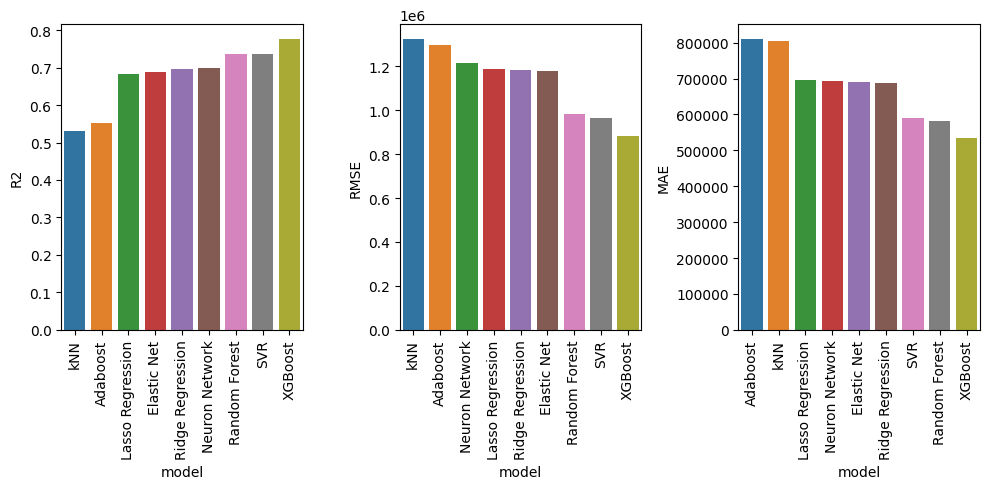

In [46]:

# Création de la figure et des sous-figures
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Barplot pour le score R2_ES
sns.barplot(data=score.sort_values(by='R2_cv_log_ES'), x='model', y='R2_cv_log_ES', ax=axs[0])
axs[0].set_ylabel('R2')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le RMSE_ES
sns.barplot(data=score.sort_values(by='RMSE_ES', ascending=False), x='model', y='RMSE_ES', ax=axs[1])
axs[1].set_ylabel('RMSE')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le MAE_ES
sns.barplot(data=score.sort_values(by='MAE_ES', ascending=False), x='model', y='MAE_ES', ax=axs[2])
axs[2].set_ylabel('MAE')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Affichage de la figure
plt.tight_layout()
plt.show()

### Meilleur modèle : XGBoost

Text(0.5, 1.0, 'Valeurs réelles vs Prédictions (logarithme)')

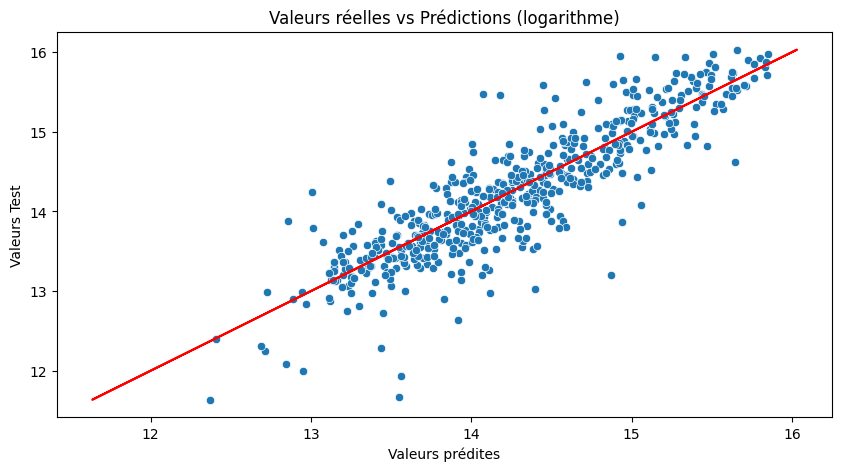

In [47]:
# Stockage du meilleur modèle dans best_model
best_model = CV_results_ES['XGBoost'].best_estimator_
y_predES = best_model.predict(X_testES)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_predES, y=y_testES)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_testES, y_testES, color='red')
plt.title('Valeurs réelles vs Prédictions (logarithme)')

#### Remise à l'échelle des valeurs

Text(0.5, 1.0, 'Valeurs réelles vs Prédictions')

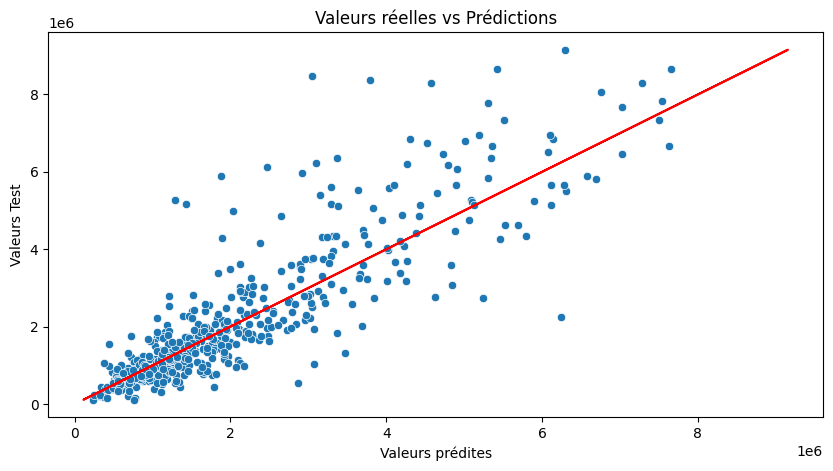

In [48]:
y_predES = best_model.predict(X_testES)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x=np.exp(y_predES), y=np.exp(y_testES))
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(np.exp(y_testES), np.exp(y_testES), color='red')
plt.title('Valeurs réelles vs Prédictions')

## Features importance

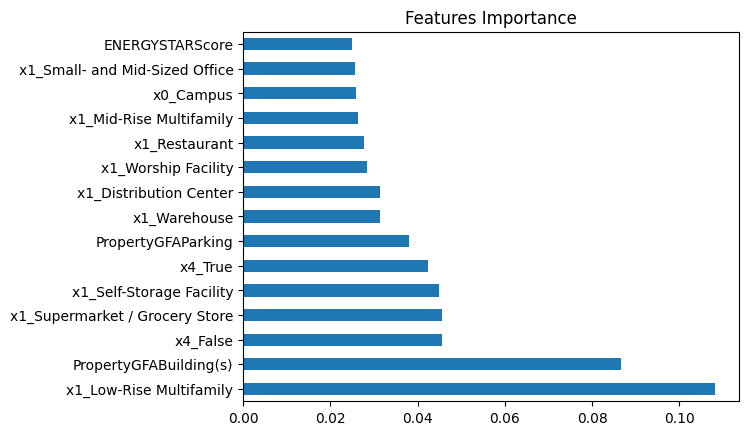

In [49]:

# Récupération des features après OneHotEncoder
num_feature_names = X.select_dtypes(include='number').columns.tolist()
cat_transformer = best_model.named_steps['preproc'].named_transformers_['cat']
cat_feature_names = cat_transformer.named_steps['one-hot'].get_feature_names_out().tolist()
feature_names = num_feature_names + cat_feature_names

# Affichage des scores d'importance des features
feature_importances = pd.Series(best_model.named_steps['model'].feature_importances_, index=feature_names)
feature_importances.nlargest(15).plot(kind='barh')
plt.title('Features Importance')
plt.show()

In [50]:
feature_importances['ENERGYSTARScore']

0.0249024

# Comparaison des modèles avec et sans ES

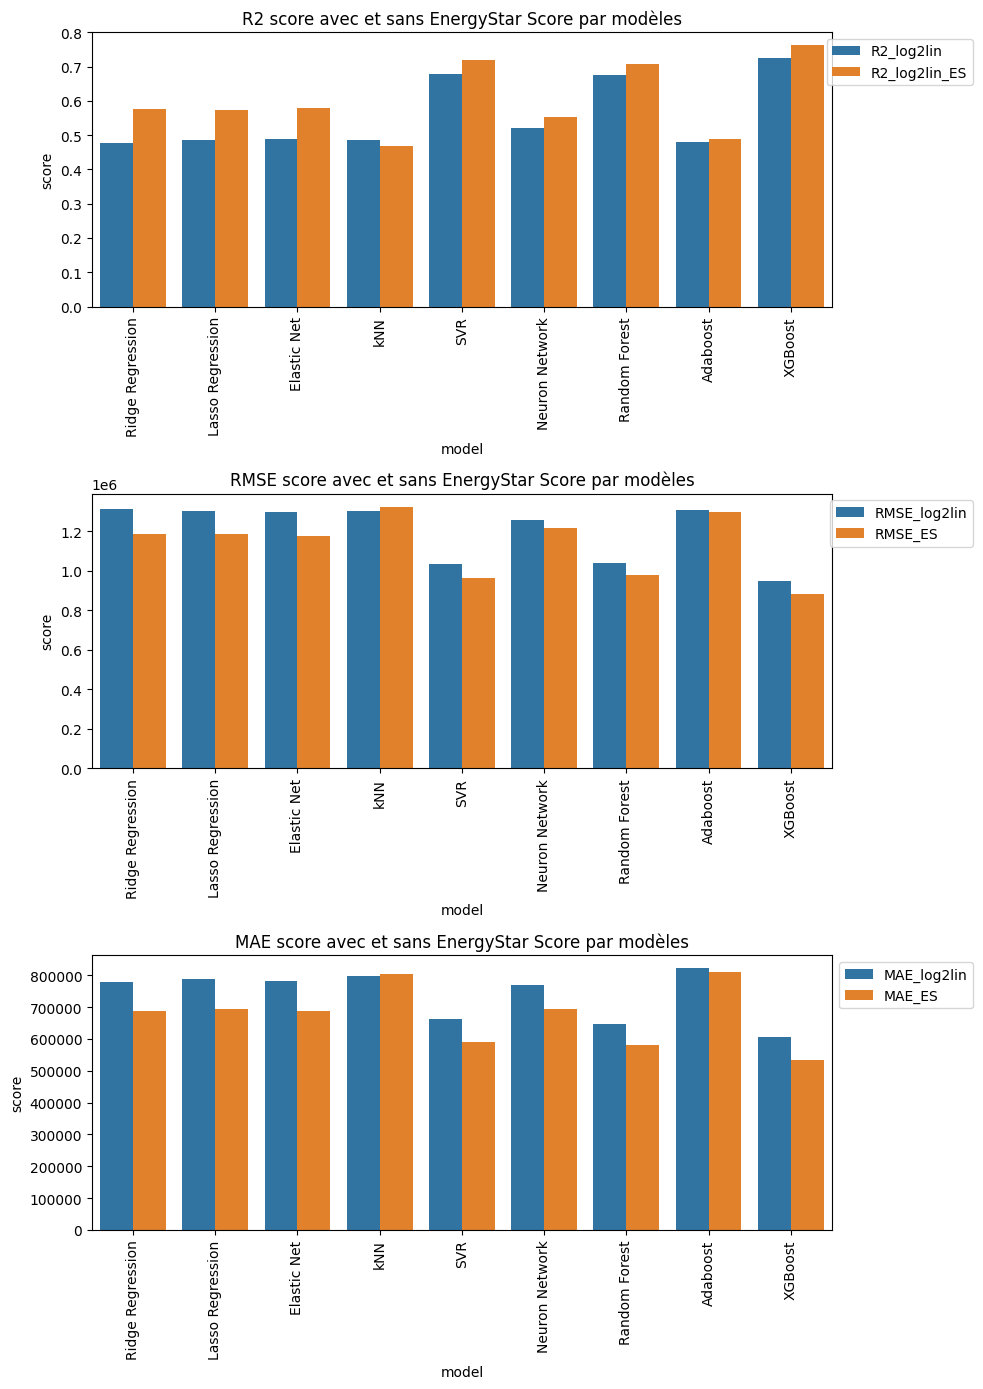

In [51]:
# Création de la figure et des sous-figures
fig, axs = plt.subplots(3, 1, figsize=(10, 14))

# Mise en forme du df avec les scores R2 par modèles
ES_compare_R2 = score.melt(id_vars=['model'], value_vars=['R2_log2lin', 'R2_log2lin_ES'], var_name='metric', value_name='score')

# Mise en forme du df avec les scores RMSE par modèles
ES_compare_RMSE = score.melt(id_vars=['model'], value_vars=['RMSE_log2lin', 'RMSE_ES'], var_name='metric', value_name='score')

# Mise en forme du df avec les scores MAE par modèles
ES_compare_MAE = score.melt(id_vars=['model'], value_vars=['MAE_log2lin', 'MAE_ES'], var_name='metric', value_name='score')

# Affichage des scores R2 en fonction du modèles avec et sans ES
sns.barplot(data=ES_compare_R2, x='model', y='score', hue='metric', ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90) # rotation de 90 degrés
axs[0].legend(bbox_to_anchor=(1.2, 1))
axs[0].title.set_text('R2 score avec et sans EnergyStar Score par modèles')

# Affichage des scores RMSE en fonction du modèles avec et sans ES
sns.barplot(data=ES_compare_RMSE, x='model', y='score', hue='metric', ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90) # rotation de 90 degrés
axs[1].legend(bbox_to_anchor=(1.2, 1))
axs[1].title.set_text('RMSE score avec et sans EnergyStar Score par modèles')

# Affichage des scores MAE en fonction du modèles avec et sans ES
sns.barplot(data=ES_compare_MAE, x='model', y='score', hue='metric', ax=axs[2])
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90) # rotation de 90 degrés
axs[2].legend(bbox_to_anchor=(1.2, 1))
axs[2].title.set_text('MAE score avec et sans EnergyStar Score par modèles')

fig.tight_layout()

# Comparaison XGBoost avec et sans ES

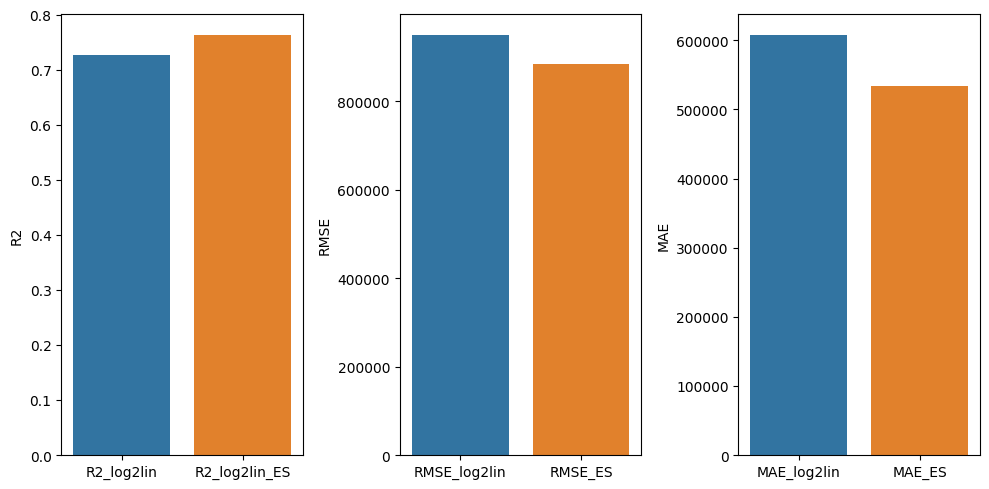

In [52]:

# Création de la figure et des sous-figures
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Barplot pour le score R2
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['R2_log2lin', 'R2_log2lin_ES']], ax=axs[0])
axs[0].set_ylabel('R2')
# Barplot pour le RMSE
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['RMSE_log2lin', 'RMSE_ES']], ax=axs[1])
axs[1].set_ylabel('RMSE')

# Barplot pour le MAE
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['MAE_log2lin', 'MAE_ES']], ax=axs[2])
axs[2].set_ylabel('MAE')

# Affichage de la figure
plt.tight_layout()
plt.show()

In [53]:
# Amélioration des score avec ES pour XGBoost

print('Amélioration R2 : +{} %'.format(round(((score.at[8, 'R2_cv_log_ES'] - score.at[8, 'R2_cv_log'] ) * 100),3)))
print('Amélioration RMSE : {} %'.format(round(((score.at[8, 'RMSE_ES'] - score.at[8, 'RMSE_log2lin']) / (score.at[8, 'RMSE_ES'] + score.at[8, 'RMSE_log2lin']) *100),4)))
print('Amélioration MAE : {} %'.format(round(((score.at[8, 'MAE_ES'] - score.at[8, 'MAE_log2lin']) / (score.at[8, 'MAE_ES'] + score.at[8, 'MAE_log2lin']) *100),4)))

Amélioration R2 : +6.1 %
Amélioration RMSE : -3.5657 %
Amélioration MAE : -6.4709 %
